# Joinig and clean the results from CIGALE

---------------------------

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import gridspec
from astropy.table import Table, Column, table, vstack, setdiff
from pathlib import Path

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:18px !important; }</style>"))

In [2]:
path_raw='../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
path_CIGALE_out = '../Datos/Work/CIGALE_Output/'
path_graphs = '../Datos/Final/Graphics/'
path_FINAL = '../Datos/Final/'

out = ['/out_0a90/','/out_30y70/']

-----------------------
## Joining the results of each results groups from CIGALE 

Read and join all the results of CIGALE of each group:
- **out_0a90:** Are the results for the setup **pcigale.ini** with skirtor2016 parameters of i = 0 to 90 in steps of 10 and oa = 40
- **out_30y70:** Are the results for the setup **pcigale.ini** with skirtor2016 parameters of i = 30 and 70 in steps and oa = 10, 40 and 70

Number of galaxys in group 1 :  117
Number of galaxys in group 2 :  59
Number of galaxys in group 3 :  25
Number of galaxys in group 4 :  8
Number of galaxys in group 5 :  9
Number of galaxys in group 6 :  17
Number of galaxys in group 7 :  6
Number of galaxys in group 8 :  4
Number of galaxys in group 9 :  3
Number of galaxys in group 10 :  4
Total galaxys:  252


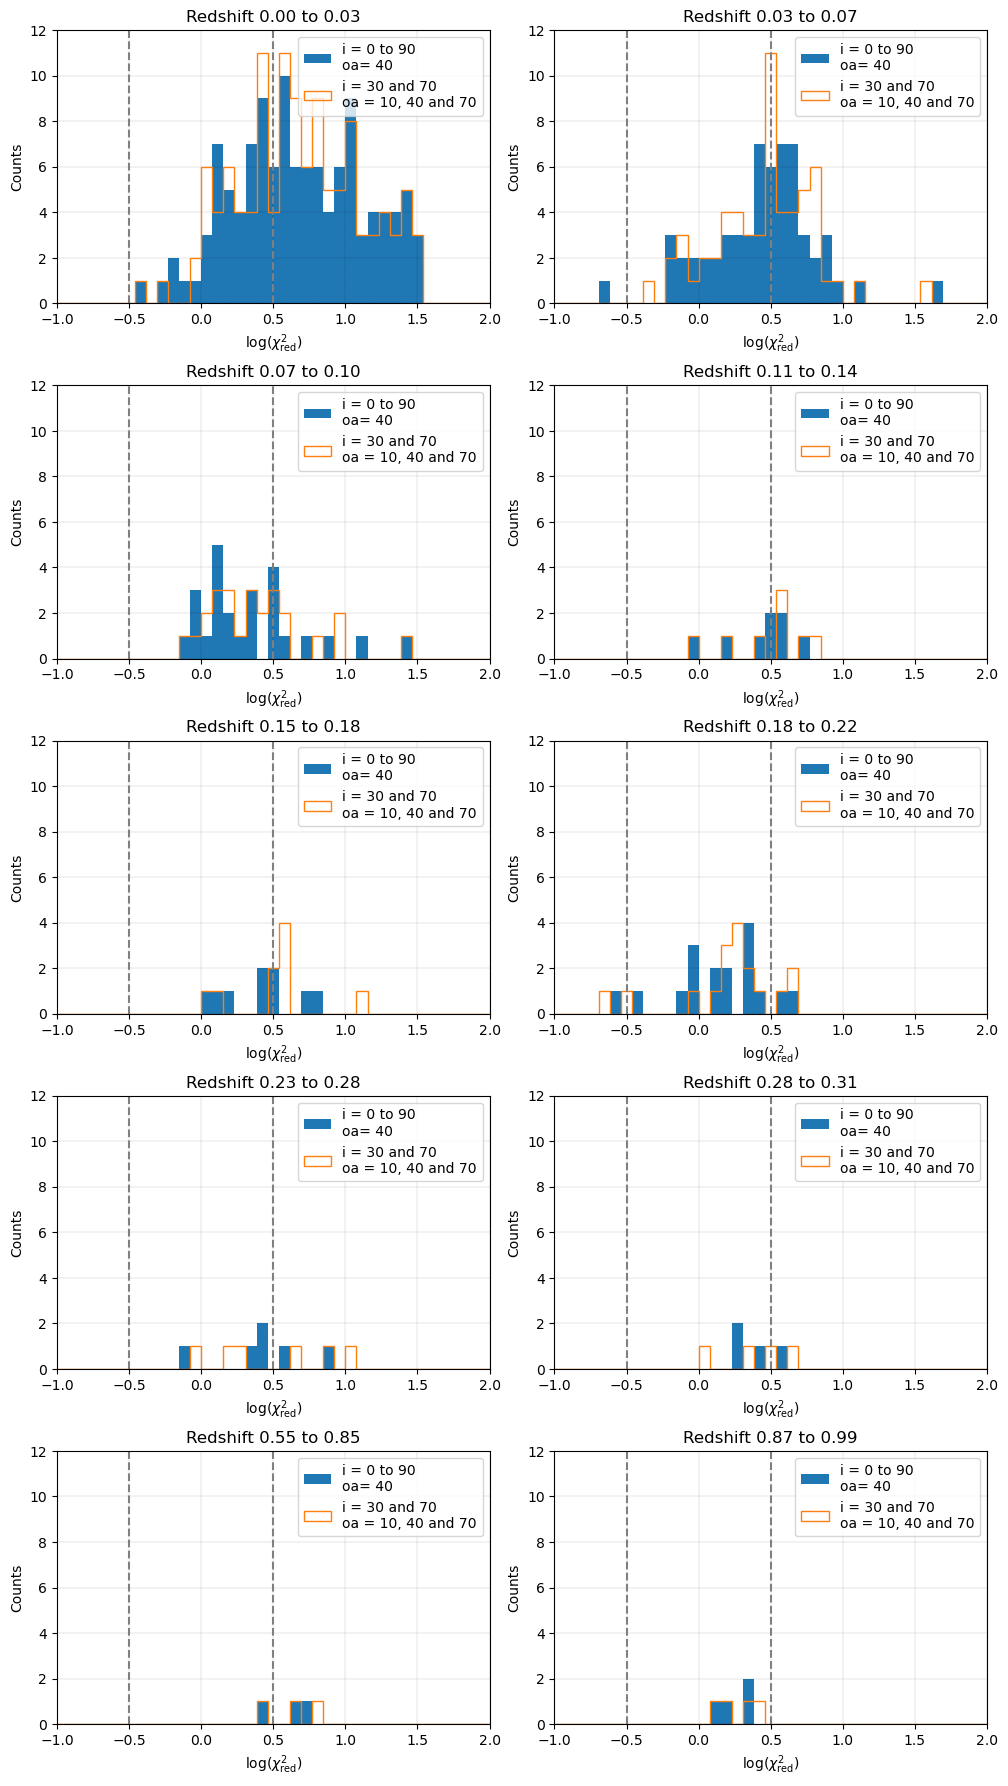

In [3]:
out0to90 = Table()
out30and70 = Table()
out_1 = Table()
out_2 = Table()
redshift_ranges = ['0.00 to 0.03','0.03 to 0.07','0.07 to 0.10','0.11 to 0.14','0.15 to 0.18',\
                   '0.18 to 0.22','0.23 to 0.28','0.28 to 0.31','0.55 to 0.85','0.87 to 0.99']
sub_plot = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1),(5,0),(5,1)]
gs = gridspec.GridSpec(5,2)
plt.subplots(figsize=(12,22),sharey=True)

for i in range(10):
    CIGPhotIn = Table()
    out0090 = Table()
    out3070 = Table()
    CIGPhotIn = Table.read(path_CIGALE_phot+'CIGPhot_EnergyBal_'+str(i+1)+'.tbl', format='ascii')
    out0090 = Table.read(path_CIGALE_out+'Group_'+str(i+1)+out[0]+'results.fits',format='fits')
    out3070 = Table.read(path_CIGALE_out+'Group_'+str(i+1)+out[1]+'results.fits',format='fits')
    
    out0090['log.reduced_chi_square'] = np.log10(out0090['best.reduced_chi_square'])
    out3070['log.reduced_chi_square'] = np.log10(out3070['best.reduced_chi_square'])
    
    binsChiS = np.linspace(-1.0,2.0,40)  # Assuming ChiSquare bins in this ranges
    plt.subplot(gs[sub_plot[i]])
    plt.xlim(-1,2)
    plt.ylim(0,12)
    plt.hist(out0090['log.reduced_chi_square'], bins=binsChiS,label='i = 0 to 90\noa= 40')
    plt.hist(out3070['log.reduced_chi_square'], bins=binsChiS, histtype='step',label='i = 30 and 70\noa = 10, 40 and 70')
    plt.axvline(x=-0.5,ls='--',color='gray')
    plt.axvline(x=0.5,ls='--',color='gray')
    plt.title('Redshift '+redshift_ranges[i])
    plt.xlabel(r'$\log(\chi^2_{\rm{red}})$')
    plt.ylabel('Counts')
    plt.grid(color='k', linestyle='--', linewidth=0.1)
    plt.legend()
    plt.subplots_adjust(hspace=0.3,wspace=0.15) #Space between subplots
    
    print('Number of galaxys in group',i+1,': ',len(out0090))
    
    out0to90 = vstack([out0090, out0to90]) #Join all the result tables from CIGALE
    out30and70 = vstack([out3070, out30and70]) #Join all the result tables from CIGALE
    
    out_1 = vstack([out0090, out_1]) #Join all the result tables from CIGALE
    out_2 = vstack([out3070, out_2]) #Join all the result tables from CIGALE

plt.savefig(path_graphs+'histo_CIGALE_fitting_groups.jpg')
    
print('Total galaxys: ',len(out0to90))
#print('Total galaxys: ',len(out_1))

### Comparing the results of each setup of 'pcigale.ini'

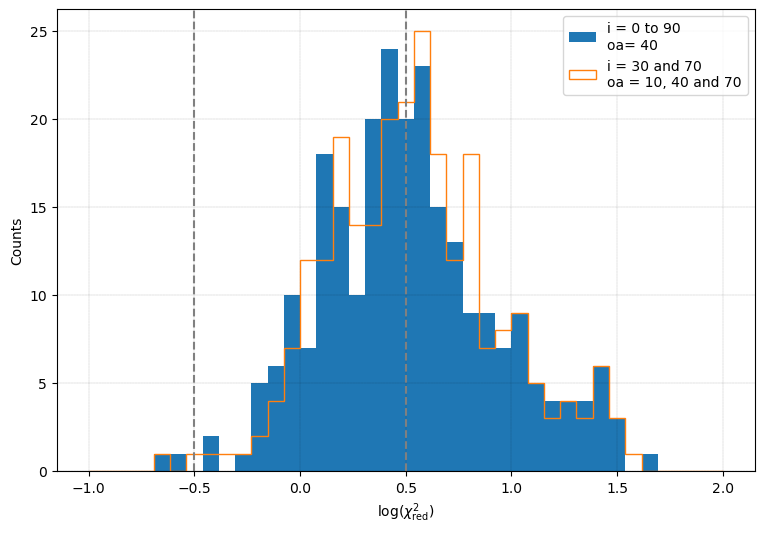

In [4]:
binsChiS = np.linspace(-1.0, 2.0, 40)  # Assuming ChiSquare bins in this ranges
plt.figure(figsize=(9,6))
plt.hist(out0to90['log.reduced_chi_square'], bins=binsChiS,label='i = 0 to 90\noa= 40')
plt.hist(out30and70['log.reduced_chi_square'], bins=binsChiS, histtype='step',\
         label='i = 30 and 70\noa = 10, 40 and 70')
plt.axvline(x=-0.5,ls='--',color='gray')
plt.axvline(x=0.5,ls='--',color='gray')
plt.xlabel(r'$\log(\chi^2_{\rm{red}})$')
plt.ylabel('Counts')
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.legend()
plt.savefig(path_graphs+'histo_CIGALE_fitting.jpg')

Re-order the two tables by id according the general table from the input data of CIGALE (Notebook 4):

In [5]:
Phot = Table.read(path_FINAL+'CIGPhot_EnergyBal_All.tbl', format='ascii')
Nbands = [sum(~np.isnan(list(row)[2::2])) for row in Phot]
out0to90 = out0to90[np.concatenate([np.where(out0to90['id'] == oid)[0] for oid in Phot['id']])]
out30and70 = out30and70[np.concatenate([np.where(out30and70['id'] == oid)[0] for oid in Phot['id']])]

Calculating the average difference of the $\chi^2_{\rm{red}}$ between the two setups of "pcigale.ini"

In [6]:
diff_models = out0to90['best.reduced_chi_square'] - out30and70['best.reduced_chi_square']
print(r'Average difference between reduced chi-square:', 
      np.round(np.mean(np.abs(diff_models)), 3))

Average difference between reduced chi-square: 0.536


In [7]:
out = vstack([out0to90, out30and70])
out = out[np.concatenate([np.where(out['id'] == oid)[0] for oid in Phot['id']])]
#out['id','best.reduced_chi_square','log.reduced_chi_square','bayes.agn.i'].show_in_notebook()

-----------------------------------
## Joinig the two configurations results from pcigale.ini

### Selecting the model with the $\chi_{\rm{red}}^{2}$ nearer to 1.0

Selecting models between the two configurations of pcinale.ini used in CIGALE based in the model with the better fit with the criteria that a $\chi_{\rm{red}}^{2} = 1.0$ means the best fit

In [8]:
#Re-order the two tables by id according the general table from the input data of CIGALE (Notebook 4):
out_1 = out_1[np.concatenate([np.where(out_1['id'] == oid)[0] for oid in Phot['id']])]
out_2 = out_2[np.concatenate([np.where(out_2['id'] == oid)[0] for oid in Phot['id']])]

to_rem_o1 = [] #Rows to be deleted or removed in out_1
to_rem_o2 = [] #Rows to be deleted or removed in out_2

for i in range(len(Phot)):
    a = abs(out_1['log.reduced_chi_square'][i])-0
    b = abs(out_2['log.reduced_chi_square'][i])-0
    #print('a =',a,'b =',b)
    if a < b:
        to_rem_o2.append(i)
    elif b < a:
        to_rem_o1.append(i)
    elif a == b:
        to_rem_o2.append(i)
#print(to_rem_o1)
#print(to_rem_o2)

out_1.remove_rows(to_rem_o1)
out_2.remove_rows(to_rem_o2)

print('Number of galaxies from out0to90:',len(out_1),'. Number of galaxies from out40and70:',len(out_2))
print('Total galaxies:',len(out_1)+len(out_2))

out_bestChi = vstack([out_1, out_2])
out_bestChi = out_bestChi[np.concatenate([np.where(out_bestChi['id'] == oid)[0] for oid in Phot['id']])]
#out_bestChi['id','log.reduced_chi_square'].show_in_notebook()

Number of galaxies from out0to90: 144 . Number of galaxies from out40and70: 108
Total galaxies: 252


### Selecting models by the $\Delta \text{BIC}$ criteria

In [9]:
out0to90['DBIC'] = out0to90['best.chi_square'] - out30and70['best.chi_square'] + np.log(Nbands)
out30and70['DBIC'] = out30and70['best.chi_square'] - out0to90['best.chi_square'] + np.log(Nbands)
out0_90_clean = out0to90[np.logical_and.reduce([out0to90['DBIC'] < 2])]
out30_70_clean = out30and70[np.logical_and.reduce([out30and70['DBIC'] < 2])]

print('Number of galaxies from out0to90:',len(out0_90_clean),'. Number of galaxies from out40and70:',len(out30_70_clean))
print('Total galaxies:',len(out0_90_clean)+len(out30_70_clean))

out_DBIC = vstack([out0_90_clean, out30_70_clean])
out_DBIC = out_DBIC[np.concatenate([np.where(out_DBIC['id'] == oid)[0] for oid in Phot['id']])]
#out_DBIC['id','log.reduced_chi_square'].show_in_notebook()

Number of galaxies from out0to90: 113 . Number of galaxies from out40and70: 85
Total galaxies: 198


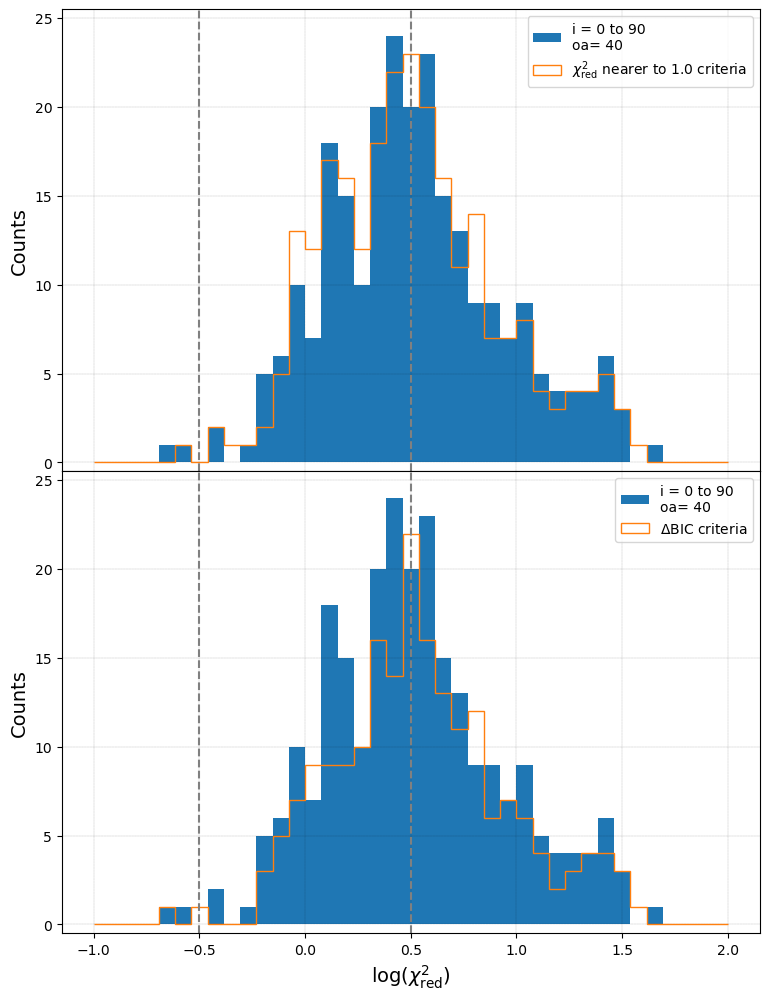

In [10]:
binsChiS = np.linspace(-1.0, 2.0, 40)  # Assuming ChiSquare bins in this ranges
plt.figure(figsize=(9,12))

ax1 = plt.subplot(211)
ax1.hist(out0to90['log.reduced_chi_square'], bins=binsChiS,label='i = 0 to 90\noa= 40')
ax1.hist(out_bestChi['log.reduced_chi_square'], bins=binsChiS, histtype='step',label=r'$\chi^2_{\rm{red}}$ nearer to 1.0 criteria')
ax1.axvline(x=-0.5,ls='--',color='gray')
ax1.axvline(x=0.5,ls='--',color='gray')
#ax1.set_xlabel(r'$\log(\chi^2_{\rm{red}})$', fontsize=14)
ax1.set_ylabel(r'Counts', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.1)
ax1.set_ylim(-0.5,25.5)
ax1.legend()

ax2 = plt.subplot(212,sharex=ax1,sharey=ax1)
ax2.hist(out0to90['log.reduced_chi_square'], bins=binsChiS,label='i = 0 to 90\noa= 40')
ax2.hist(out_DBIC['log.reduced_chi_square'], bins=binsChiS, histtype='step',label=r'$\Delta{\rm{BIC}}$ criteria')
ax2.axvline(x=-0.5,ls='--',color='gray')
ax2.axvline(x=0.5,ls='--',color='gray')
ax2.set_xlabel(r'$\log(\chi^2_{\rm{red}})$', fontsize=14)
ax2.set_ylabel(r'Counts', fontsize=14)
ax2.grid(color='k', linestyle='--', linewidth=0.1)
ax2.legend()

plt.subplots_adjust(hspace=0.0) #Space between subplots
plt.savefig(path_graphs+'histo_CIGALE_fitting_i0to90vsbestChivsBIC.jpg')

## Cleaning the results from CIGALE

Now we are goint to remove the galaxies with bad fittings: $\chi_{\rm{red}}^{2}$ higher than $10^{0.5}$ (Underestimated) and lower than $10^{-0.5}$ (Overestimated) and the galaxies with a bad constrained SFR.

In [11]:
GoodSFR_out0to90 = (out0to90['bayes.sfh.sfr_err'] / (out0to90['bayes.sfh.sfr']*np.log(10))) <= 1
GoodSFR_out30and70 = (out30and70['bayes.sfh.sfr_err'] / (out30and70['bayes.sfh.sfr']*np.log(10))) <= 1
GoodSFR_out_bestChi = (out_bestChi['bayes.sfh.sfr_err'] / (out_bestChi['bayes.sfh.sfr']*np.log(10))) <= 1
GoodSFR_out_DBIC = (out_DBIC['bayes.sfh.sfr_err'] / (out_DBIC['bayes.sfh.sfr']*np.log(10))) <= 1

GoodSM_out0to90 = (out0to90['bayes.stellar.m_star_err']/(out0to90['bayes.stellar.m_star']*np.log(10))) <= 1
GoodSM_out30and70 = (out30and70['bayes.stellar.m_star_err']/(out30and70['bayes.stellar.m_star']*np.log(10))) <= 1
GoodSM_out_bestChi = (out_bestChi['bayes.stellar.m_star_err']/(out_bestChi['bayes.stellar.m_star']*np.log(10))) <= 1
GoodSM_out_DBIC = (out_DBIC['bayes.stellar.m_star_err']/(out_DBIC['bayes.stellar.m_star']*np.log(10))) <= 1


out0to90_clean = out0to90[np.logical_and.reduce([out0to90['best.reduced_chi_square'] <= 10**0.5, \
                                            out0to90['best.reduced_chi_square'] >= 10**-0.5,GoodSFR_out0to90])]

out30and70_clean = out30and70[np.logical_and.reduce([out30and70['best.reduced_chi_square'] <= 10**0.5, \
                                            out30and70['best.reduced_chi_square'] >= 10**-0.5,GoodSFR_out30and70])]

out_bestChi_clean = out_bestChi[np.logical_and.reduce([out_bestChi['best.reduced_chi_square'] <= 10**0.5, \
                                            out_bestChi['best.reduced_chi_square'] >= 10**-0.5,GoodSFR_out_bestChi])]

out_DBIC_clean = out_DBIC[np.logical_and.reduce([out_DBIC['best.reduced_chi_square'] <= 10**0.5, \
                                            out_DBIC['best.reduced_chi_square'] >= 10**-0.5,GoodSFR_out_DBIC])]

Number of galaxies removed after the cleaining

In [12]:
removed_galaxies_1 = len(out0to90)-len(out0to90_clean)
removed_galaxies_2 = len(out30and70)-len(out30and70_clean)
removed_galaxies_3 = len(out_bestChi)-len(out_bestChi_clean)
removed_galaxies_4 = len(out_DBIC)-len(out_DBIC_clean)
print('The number of galaxies removed in out0to90 are:',removed_galaxies_1,'from',len(out0to90))
print('The number of galaxies removed in out30and70:',removed_galaxies_2,'from',len(out30and70))
print('The number of galaxies removed in out_bestChi:',removed_galaxies_3,'from',len(out_bestChi))
print('The number of galaxies removed in out_DBIC:',removed_galaxies_4,'from',len(out_DBIC))

The number of galaxies removed in out0to90 are: 134 from 252
The number of galaxies removed in out30and70: 149 from 252
The number of galaxies removed in out_bestChi: 133 from 252
The number of galaxies removed in out_DBIC: 115 from 198


In [13]:
out0to90_clean = out0to90_clean[np.concatenate([np.where(out0to90_clean['id'] == oid)[0] for oid in Phot['id']])]
out30and70_clean = out30and70_clean[np.concatenate([np.where(out30and70_clean['id'] == oid)[0] for oid in Phot['id']])]
out_bestChi_clean = out_bestChi_clean[np.concatenate([np.where(out_bestChi_clean['id'] == oid)[0] for oid in Phot['id']])]
out_DBIC_clean = out_DBIC_clean[np.concatenate([np.where(out_DBIC_clean['id'] == oid)[0] for oid in Phot['id']])]

out0to90_clean.write(path_CIGALE_out+'results0a90_All.fits', format='fits',overwrite=True)
out0to90_clean.write(path_CIGALE_out+'results0a90_All.txt', format='ascii',overwrite=True)

out30and70_clean.write(path_CIGALE_out+'results30y70_All.fits', format='fits',overwrite=True)
out30and70_clean.write(path_CIGALE_out+'results30y70_All.txt', format='ascii',overwrite=True)

out_bestChi_clean.write(path_CIGALE_out+'results_bestChi.fits', format='fits',overwrite=True)
out_bestChi_clean.write(path_CIGALE_out+'results_bestChi.txt', format='ascii',overwrite=True)

out_DBIC_clean.write(path_CIGALE_out+'resultsDBIC_All.fits', format='fits',overwrite=True)
out_DBIC_clean.write(path_CIGALE_out+'resultsDBIC_All.txt', format='ascii',overwrite=True)

In [14]:
print('Final number of galaxies for out0to90 are:',len(out0to90_clean))
print('Final number of galaxies for out30and70:',len(out30and70_clean))
print('Final number of galaxies for out_bestChi:',len(out_bestChi_clean))
print('Final number of galaxies for out_DBIC:',len(out_DBIC_clean))

Final number of galaxies for out0to90 are: 118
Final number of galaxies for out30and70: 103
Final number of galaxies for out_bestChi: 119
Final number of galaxies for out_DBIC: 83


-------------------------------
## Notebook Info

In [15]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 7.31.1

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

numpy     : 1.21.5
astropy   : 5.1
matplotlib: 3.5.2

Watermark: 2.3.1



------------------------------------
### Celdas para pruebas:

In [16]:
#out0to90_clean['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.sfh.sfr','bayes.sfh.sfr_err','bayes.agn.i','bayes.agn.i_err','best.reduced_chi_square']

In [17]:
#out30and70_clean['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i','bayes.agn.i_err','best.reduced_chi_square']

In [18]:
#out_bestChi_clean['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.sfh.sfr','bayes.sfh.sfr_err','bayes.agn.i','bayes.agn.i_err','best.reduced_chi_square']

In [19]:
#out_DBIC_clean['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.sfh.sfr','bayes.sfh.sfr_err','bayes.agn.i','bayes.agn.i_err','best.reduced_chi_square']